# Deep Learning- Inference Notebook (already ran)
Ido Natan (ID. 305727802), Doron Nevo (ID. 55088082)

bookidodo@gmail.com, nevo.doron@live.biu.ac.il

# README:

Please upload a **ZIP** containing your custom test images.
The images should be in the size of 256X256.

*Note*: to keep order each upload we remove previous uploaded images.

We have prepared test images of our own if you prefer not upload.



Please make sure to run the notebook in a **Cuda** environment. 
Runtime --> Change runtime type --> GPU.

Please make sure to run the notebook in **Chrome** due to bug with firefox concerning 'from google.colab import files'

# Imports

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import random
import shutil
import time
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import os
import glob


In [ ]:
# Constants and names
TEST_IMAGES_FOLDER = '/content/test_images/'
GENERATED_IMAGES_FOLDER = '/content/generated/'
TRAINED_WEIGHTS = 'current.ckpt'

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Upload custom images (or don't run this cell but run the following cell)

Please upload a **ZIP** containing your custom test images.
The images should be in the size of 256X256.

In [ ]:
from google.colab import files
uploaded_zip = files.upload()
uploaded_zip_name = next(iter(uploaded_zip))
uploaded_folder_name_path = '/content/' + uploaded_zip_name

# Use prepared images? uncomment below.

In [ ]:
# !gdown https://drive.google.com/uc?id=1jFjMjKsjdg5CKnT4XprVZK34d3Msl2kk
# uploaded_folder_name_path = '/content/5_images_jpg.zip'

Downloading...
From: https://drive.google.com/uc?id=1jFjMjKsjdg5CKnT4XprVZK34d3Msl2kk
To: /content/5_images_jpg.zip
100% 86.5k/86.5k [00:00<00:00, 1.37MB/s]


In [ ]:
# Check existance of folders and remove them for reuse.

tst_dir = os.path.isdir(TEST_IMAGES_FOLDER)
gen_dir = os.path.isdir(GENERATED_IMAGES_FOLDER)

if tst_dir:
  files = glob.glob(TEST_IMAGES_FOLDER+'*')
  for f in files:
    print(files)
    os.remove(f)
  
if gen_dir:
  files = glob.glob(GENERATED_IMAGES_FOLDER+'*')
  for f in files:
    os.remove(f)
  

!mkdir '/content/generated/'

In [ ]:
import zipfile
with zipfile.ZipFile(uploaded_folder_name_path, 'r') as zip_ref:
    zip_ref.extractall(TEST_IMAGES_FOLDER)

# Define model

In [ ]:
# Our CycleGAN model with the predefined and redefined hyerparameters
class CycleGAN(object):
    def __init__(self, device, epochs=40):
        self.n_epochs = epochs
        self.n_epochs_decay = int(self.n_epochs/2)
        self.lambda_P = 10
        self.lambda_M = 10
        self.lambda_idt = 0.5
        self.start_lr = 2e-4
        self.device = device
        self.netG_M = Generator()
        self.netG_P = Generator()
        self.netD_M = Discriminator()
        self.netD_P = Discriminator()
        self.netG_M = self.netG_M.to(self.device)
        self.netG_P = self.netG_P.to(self.device)
        self.netD_M = self.netD_M.to(self.device)
        self.netD_P = self.netD_P.to(self.device)

        self.criterionGAN = nn.MSELoss()
        self.criterionCycle = nn.L1Loss()
        self.criterionIdt = nn.L1Loss()
        self.optimizer_G = torch.optim.Adam(itertools.chain(self.netG_M.parameters(), self.netG_P.parameters()),
                                         lr=self.start_lr, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.Adam(itertools.chain(self.netD_M.parameters(), self.netD_P.parameters()),
                                          lr=self.start_lr, betas=(0.5, 0.999))
        self.fake_M_pool = ImagePool()
        self.fake_P_pool = ImagePool()
        G_lr = lr_sched(self.n_epochs_decay , self.n_epochs)
        self.G_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.optimizer_G, G_lr.step)
        D_lr = lr_sched(self.n_epochs_decay , self.n_epochs)
        self.D_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.optimizer_D, D_lr.step)
        self.losses_G = []
        self.losses_D = []
        # list of 5 photos to be evaluated in epochs
        self.real_Ps = []
        # for i in range(5):
        #     real_P, _ = next(iter(img_dl))
        #     self.real_Ps.append(real_P)


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        model = list()
        model.append(nn.ReflectionPad2d(3))

        model.append(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=0, bias=True))
        model.append(nn.InstanceNorm2d(num_features=64))
        model.append(nn.ReLU())

        model.append(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True))
        model.append(nn.InstanceNorm2d(num_features=128))
        model.append(nn.ReLU())

        model.append(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=True))
        model.append(nn.InstanceNorm2d(num_features=256))
        model.append(nn.ReLU())

        for _ in range(9):      # 9 Res blocks  @@
            model.append(Resblock())

        model.append(nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1))
        model.append(nn.InstanceNorm2d(num_features=128))
        model.append(nn.Dropout(p=0.5))
        model.append(nn.ReLU())

        model.append(nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1))
        model.append(nn.InstanceNorm2d(num_features=64))
        model.append(nn.Dropout(p=0.5))
        model.append(nn.ReLU())

        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding=0))
        model.append(nn.Tanh())

        self.gen = nn.Sequential(*model)

    def forward(self, x):
        return self.gen(x)

In [ ]:
class Resblock(nn.Module):
    def __init__(self):
        super().__init__()
        layers = list()
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0, bias=True))
        layers.append(nn.InstanceNorm2d(num_features=256))
        layers.append(nn.ReLU())

        layers.append(nn.Dropout(p=0.5))
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=0, bias=True))
        layers.append(nn.InstanceNorm2d(num_features=256))
        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.res(x)  # skip connection at end of Res block

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        model = list()
        model.append(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1))
        model.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))

        model.append(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=1, padding=1, bias=True))
        model.append(nn.InstanceNorm2d(num_features=128))
        model.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))

        model.append(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=1, padding=1, bias=True))
        model.append(nn.InstanceNorm2d(num_features=256))
        model.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))

        model.append(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=True))
        model.append(nn.InstanceNorm2d(num_features=512))
        model.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))

        model.append(nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=1))
        self.disc = nn.Sequential(*model)

    def forward(self, x):
        return self.disc(x)

In [ ]:
# Save 50 generated fake images and sample through them
# to feed discriminators to avoid large oscillations 
# from iterations to iterations. (refer to CycleGAN orginal paper, section 4)
class ImagePool(object):
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        self.cur_image = 0
        self.pool = []

    def __call__(self, image):
        if self.cur_image < self.pool_size:
            self.pool.append(image)
            ret = image
            self.cur_image += 1
        else:
            if np.random.ranf() > 0.5:
                idx = np.random.randint(0, self.pool_size)
                ret = self.pool[idx]
                self.pool[idx] = image
            else:
                ret = image
        return ret

In [ ]:
# The learning rate should change in the following way: 
class lr_sched():
    def __init__(self, n_epochs_decay , n_epochs):
        self.n_epochs_decay  = n_epochs_decay 
        self.n_epochs = n_epochs

    def step(self, epoch_num):
        if epoch_num <= self.n_epochs_decay :
            return 1.0
        else:
            fract = (epoch_num - self.n_epochs_decay )  / (self.n_epochs - self.n_epochs_decay)
            return 1.0 - fract

In [ ]:
# Finally prepare the unnorm function as required in the article.
def unnorm(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
        
    return img

# Load trained weights

In [ ]:
!gdown https://drive.google.com/uc?id=1-1vstT4a_sUK7E41R6YBQzHRagx35RqU

Downloading...
From: https://drive.google.com/uc?id=1-1vstT4a_sUK7E41R6YBQzHRagx35RqU
To: /content/current.ckpt
340MB [00:03, 102MB/s]


In [ ]:
gan = CycleGAN(device)

In [ ]:
print("=> loading trained weights '{}'".format(TRAINED_WEIGHTS))
checkpoint = torch.load(TRAINED_WEIGHTS)
epoch_count = checkpoint['epoch']
gan.netG_M.load_state_dict(checkpoint['netG_M'])
gan.netG_P.load_state_dict(checkpoint['netG_P'])
gan.netD_M.load_state_dict(checkpoint['netD_M'])
gan.netD_P.load_state_dict(checkpoint['netD_P'])
gan.optimizer_G.load_state_dict(checkpoint['optimizer_gen'])
gan.optimizer_D.load_state_dict(checkpoint['optimizer_desc'])

=> loading trained weights 'current.ckpt'


In [ ]:
class PhotoDataset(Dataset):
    def __init__(self, photo_dir):
        super().__init__()
        self.photo_dir = photo_dir
        self.photo_idx = dict()
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
        ])
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    def __getitem__(self, idx):
        photo_path = os.path.join(self.photo_dir, self.photo_idx[idx])
        real_P = Image.open(photo_path)
        real_P = self.transform(real_P)
        return real_P, self.photo_idx[idx]

    def __len__(self):
        return len(self.photo_idx.keys())

# Export Generated Monet Photos

In [ ]:
ph_ds = PhotoDataset(TEST_IMAGES_FOLDER)
ph_dl = DataLoader(ph_ds, batch_size=1, pin_memory=True)

trans = transforms.ToPILImage()
t = tqdm(ph_dl, leave=False, total=ph_dl.__len__())
for i, (real_P, img_name) in enumerate(t):
    with torch.no_grad():
        fake_M = gan.netG_P(real_P.to(device)).cpu().detach()
    fake_M = unnorm(fake_M)
    img = trans(fake_M[0]).convert("RGB")

    img.save("/content/generated/" + img_name[0][:-4] + "_M.jpg")

# Show Test Images vs Generated Images

In [ ]:
# Convert the directories to lists

from os import listdir
from PIL import Image as PImage

def loadImages(path):
    # return array of images

    imagesList = listdir(path)
    imagesList.sort()
    loadedImages = []
    for image in imagesList:
        img = PImage.open(path + image)
        loadedImages.append(img)

    return loadedImages

real_path = TEST_IMAGES_FOLDER
generated_path = GENERATED_IMAGES_FOLDER

# images in an array
test_imgs = loadImages(real_path)
generated_imgs = loadImages(generated_path)

Test Images vs Generated Images


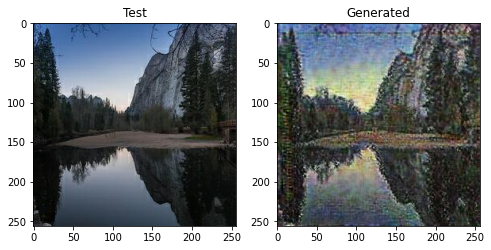

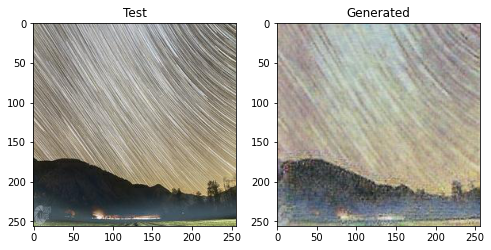

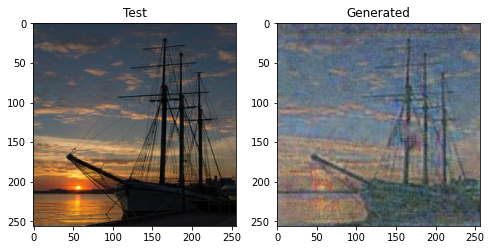

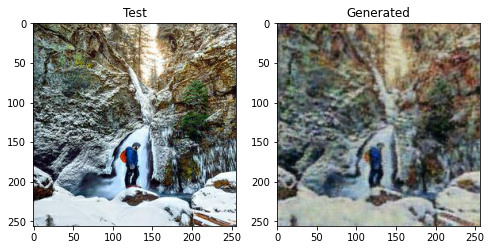

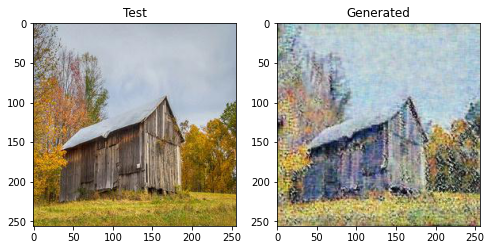

In [ ]:
# Show test images vs generated images
for i in range(len(test_imgs)):
  f = plt.figure(figsize=(8, 8))
  f.add_subplot(1, 2, 1)
  plt.title('Test')
  # original = unnorm(original)
  plt.imshow(test_imgs[i])
  f.add_subplot(1, 2, 2)
  plt.title('Generated')
  # generated = unnorm(generated)
  plt.imshow(generated_imgs[i])
print('Test Images vs Generated Images')
